<a href="https://www.kaggle.com/code/musowir/img-captions?scriptVersionId=123789242" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Step 1:- Import the required libraries

In [2]:
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from tensorflow.keras.layers import add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from pathlib import Path
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pickle

Step 2:- Data loading and Preprocessing

In [3]:

image_path = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images"
dir_Flickr_text = "/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv"
#features_path = '/kaggle/input/features/features'
features_path = '/kaggle/working/VGG19'
if not os.path.exists(features_path):
    os.makedirs(features_path)
jpgs = os.listdir(image_path)

print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 31785


We create a dataframe to store the image id and captions for ease of use.

In [4]:
# file = open(dir_Flickr_text,'r')
# text = file.read()
# file.close()

# datatxt = []
# for line in text.split('\n'):
#    col = line.split('\t')
#    if len(col) == 1:
#        continue
#    w = col[0].split("#")
#    datatxt.append(w + [col[1].lower()])

data = pd.read_csv(dir_Flickr_text, delimiter="|")
#data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data.columns = ["filename","index","caption"]
data = data.reindex(columns =['index','filename','caption'])
data.dropna(inplace=True)
uni_filenames = np.unique(data.filename.values)

data.head()

,index,filename,caption
0,0,1000092795.jpg,Two young guys with shaggy hair look at their...
1,1,1000092795.jpg,"Two young , White males are outside near many..."
2,2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,4,1000092795.jpg,Two friends enjoy time spent together .


visualize a few images and their 5 captions:

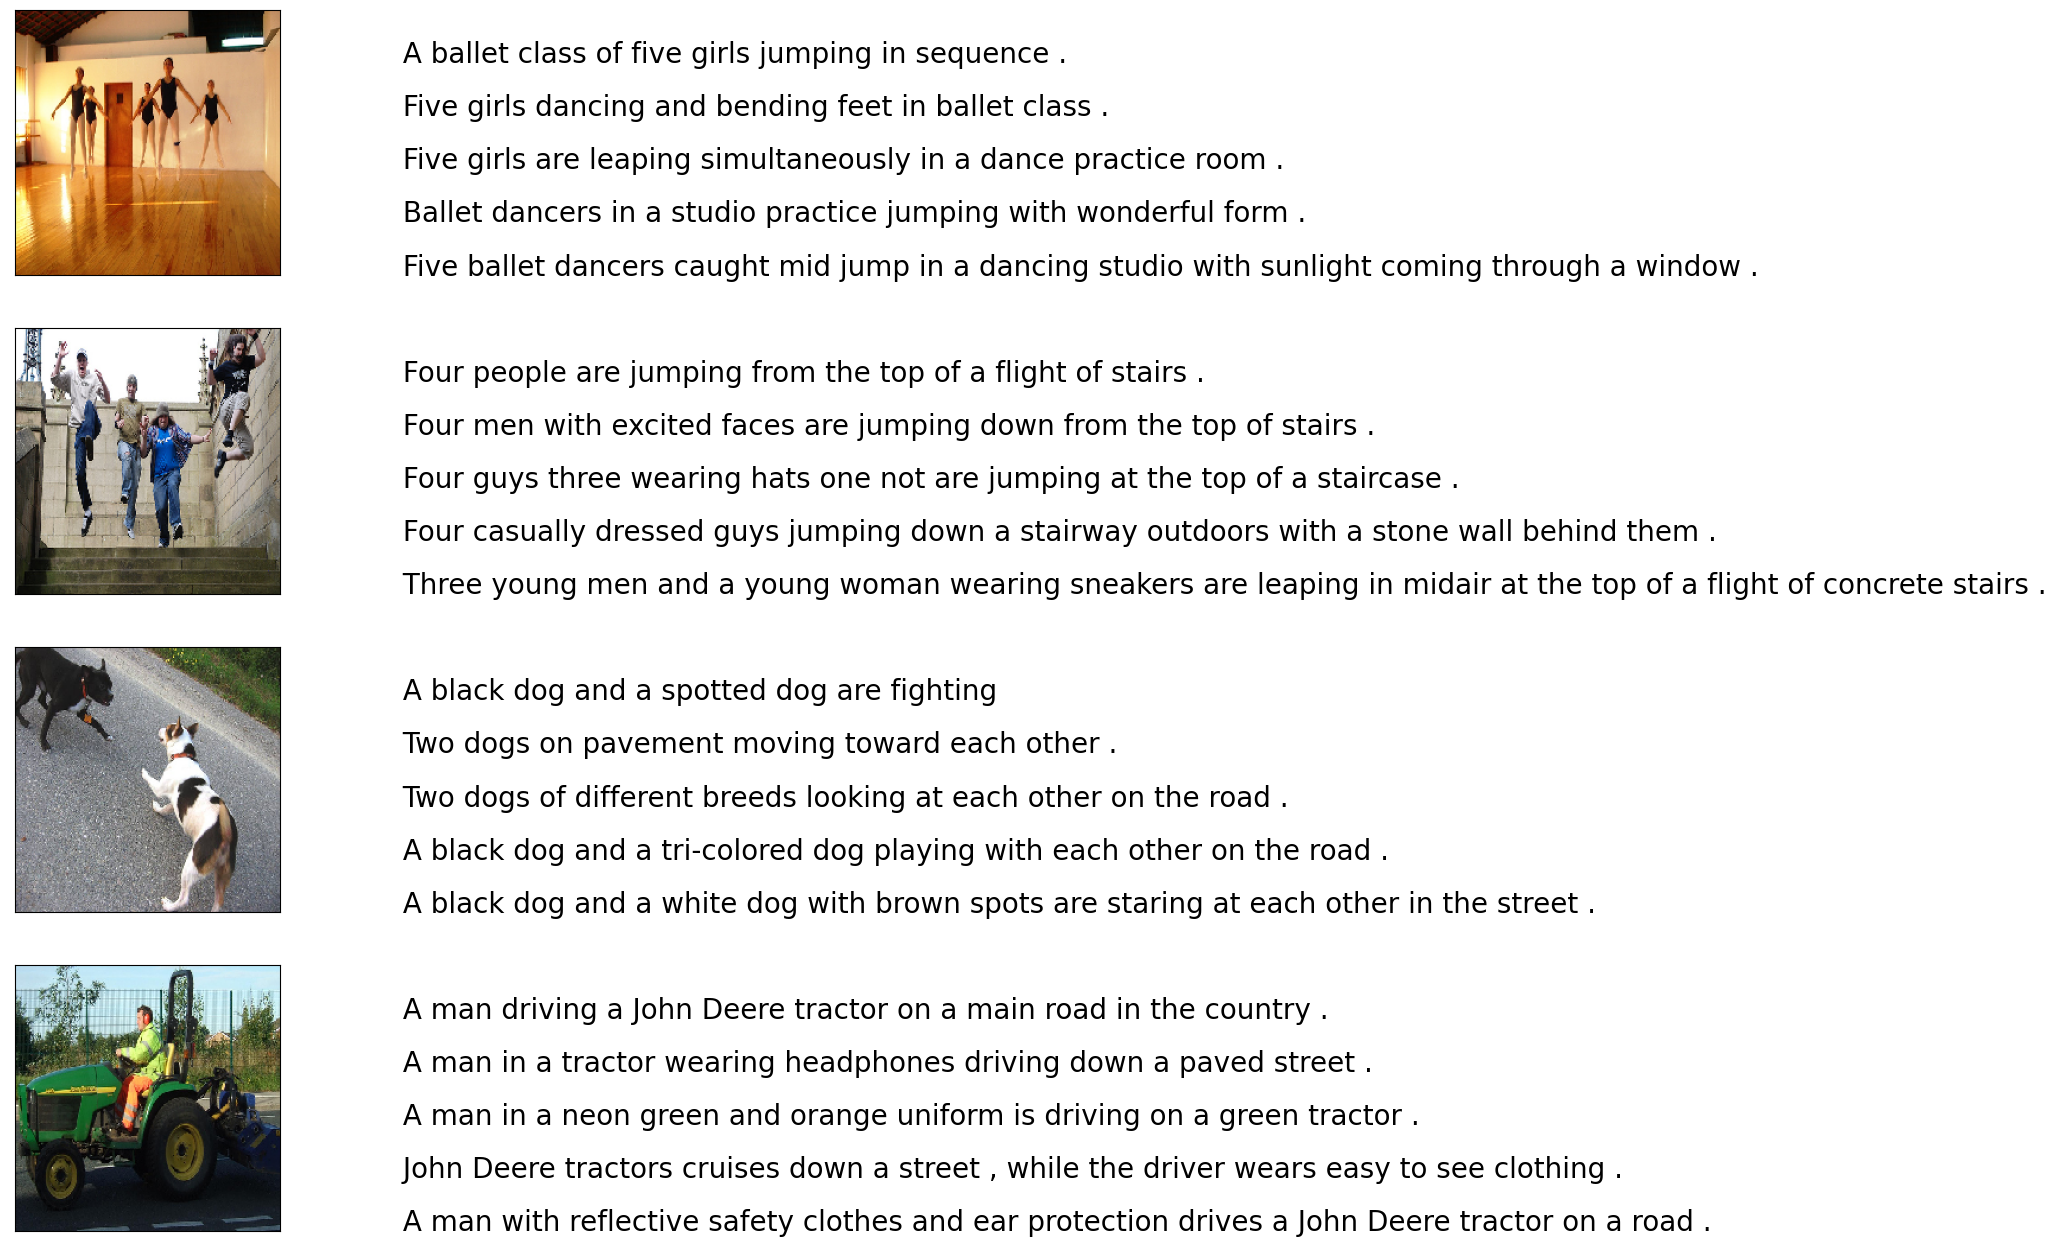

In [5]:
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1

fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:14]:
   filename = image_path + '/' + jpgfnm
   captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
   image_load = load_img(filename, target_size=target_size)
   ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
   ax.imshow(image_load)
   count += 1

   ax = fig.add_subplot(npic,2,count)
   plt.axis('off')
   ax.plot()
   ax.set_xlim(0,1)
   ax.set_ylim(0,len(captions))
   for i, caption in enumerate(captions):
       ax.text(0,i,caption,fontsize=20)
   count += 1
plt.show()

current vocabulary size is:-

In [6]:
vocabulary = []
for txt in data.caption.values:
   vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 23457


some text cleaning such as removing punctuation, single characters, and numeric values:

In [7]:
def remove_punctuation(text_original):
   text_no_punctuation = text_original.translate(string.punctuation)
   return(text_no_punctuation)

def remove_single_character(text):
   text_len_more_than1 = ""
   for word in text.split():
       if len(word) > 1:
           text_len_more_than1 += " " + word
   return(text_len_more_than1)

def remove_numeric(text):
   text_no_numeric = ""
   for word in text.split():
       isalpha = word.isalpha()
       if isalpha:
           text_no_numeric += " " + word
   return(text_no_numeric)

def text_clean(text_original):
   text = remove_punctuation(text_original)
   text = remove_single_character(text)
   text = remove_numeric(text)
   return(text)

for i, caption in enumerate(data.caption.values):
   newcaption = text_clean(caption)
   data["caption"].iloc[i] = newcaption

size of our vocabulary after cleaning

In [8]:
clean_vocabulary = []
for txt in data.caption.values:
   clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 20928


add ‘< start >’ and ‘< end >’ tags to every caption so that the model understands the starting and end of each caption

In [9]:

all_captions = []
for caption  in data["caption"].astype(str):
   caption = '<start> ' + caption+ ' <end>'
   all_captions.append(caption)

all_captions[:10]

['<start>  Two young guys with shaggy hair look at their hands while hanging out in the yard <end>',
 '<start>  Two young White males are outside near many bushes <end>',
 '<start>  Two men in green shirts are standing in yard <end>',
 '<start>  man in blue shirt standing in garden <end>',
 '<start>  Two friends enjoy time spent together <end>',
 '<start>  Several men in hard hats are operating giant pulley system <end>',
 '<start>  Workers look down from up above on piece of equipment <end>',
 '<start>  Two men working on machine wearing hard hats <end>',
 '<start>  Four men on top of tall structure <end>',
 '<start>  Three men on large rig <end>']

In [10]:
all_img_name_vector = []
for annot in data["filename"]:
   full_image_path = image_path + '/' + annot
   all_img_name_vector.append(full_image_path)

all_img_name_vector[:10]

['/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/1000092795.jpg',
 '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/1000092795.jpg',
 '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/1000092795.jpg',
 '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/1000092795.jpg',
 '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/1000092795.jpg',
 '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/10002456.jpg',
 '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/10002456.jpg',
 '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/10002456.jpg',
 '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/10002456.jpg',
 '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/10002456.jpg']

40455 image paths and captions.

In [11]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 158914
len(all_captions) : 158914


take only 40000 of each so that we can select batch size properly i.e. 625 batches if batch size= 64. To do this we define a function to limit the dataset to 40000 images and captions.

In [12]:
def data_limiter(num,total_captions,all_img_name_vector):
 train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
 train_captions = train_captions[:num]
 img_name_vector = img_name_vector[:num]
 return train_captions,img_name_vector

train_captions,img_name_vector = data_limiter(158720,all_captions,all_img_name_vector)

Step 3:- Model Definition

**vgg16**

In [13]:
def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (224, 224))
   img = preprocess_input(img)
   return img, image_path

image_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_features_extract_model.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

Map each image name to the function to load the image:-

In [14]:
#to save image_features_extract_model  

#image_features_extract_model.save('image_features_extract_model.h5')

In [15]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

extract the features and store them in the respective .npy files and then pass those features through the encoder.NPY files store all the information required to reconstruct an array on any computer, which includes dtype and shape information.

In [16]:
%%time
for img, path in tqdm(image_dataset):
 batch_features = image_features_extract_model(img)
 batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

 for bf, p in zip(batch_features, path):
   path_of_feature = Path(p.numpy().decode("utf-8"))
   image_name = path_of_feature.stem
   np.save(f'{features_path}/{image_name}', bf.numpy())

100%|██████████| 497/497 [05:22<00:00,  1.54it/s]

CPU times: user 4min 59s, sys: 14 s, total: 5min 13s
Wall time: 5min 22s


In [17]:
#to save the extracted features as zip file (to download)

# import shutil
# shutil.make_archive('/kaggle/working/VGG19', 'zip', '/kaggle/working/VGG19')

In [18]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [19]:
# Save the tokenizer to a file using pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

visualize the padded training and captions and the tokenized vectors:

In [20]:
train_captions[:3]

['<start>  legless man is walking next to man in bright yellow shirt <end>',
 '<start>  little boy in red outfit is jumping <end>',
 '<start>  The boy is kicking soccer ball <end>']

calculate the max and min length of all captions

In [21]:
def calc_max_length(tensor):
   return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)

def calc_min_length(tensor):
   return min(len(t) for t in tensor)
min_length = calc_min_length(train_seqs)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 74 : 3


In [22]:
# Save max_length to a file using pickle
with open('max_length.pkl', 'wb') as f:
    pickle.dump(max_length, f)

Create training and validation sets using an 80-20 split:

In [23]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.2, random_state=0)

In [24]:
import pickle


# Save the list to a file
with open('img_name_val.pkl', 'wb') as f:
    pickle.dump(img_name_val, f)
# Save the list to a file
with open('cap_val.pkl', 'wb') as f:
    pickle.dump(cap_val, f)

Define the parameters for training:

In [25]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49

create a tf.data dataset to use for training our model.

In [26]:
import re
def map_func(img_name, cap):
 imgn = re.split('\.|\/', img_name.decode())[-2]
 img_tensor = np.load(f'{features_path}/{imgn}'+'.npy')
 return img_tensor, cap
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
         num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

The VGG-19 Encoder is defined below:-

In [31]:
class VGG19_Encoder(tf.keras.Model):
   # This encoder passes the features through a Fully connected layer
   def __init__(self, embedding_dim):
       super(VGG19_Encoder, self).__init__()
       # shape after fc == (batch_size, 49, embedding_dim)
       self.fc = tf.keras.layers.Dense(embedding_dim)
       self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

   def call(self, x):
       #x= self.dropout(x)
       x = self.fc(x)
       x = tf.nn.relu(x)
       return x   

The Resnet encoder is defined below:-

We define our RNN based on GPU/CPU capabilities-

In [32]:
def rnn_type(units):
   if tf.test.is_gpu_available():
       return tf.compat.v1.keras.layers.CuDNNLSTM(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
   else:
       return tf.keras.layers.GRU(units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_activation='sigmoid',
                                  recurrent_initializer='glorot_uniform')

define the RNN Decoder with Bahdanau Attention:

In [33]:
'''The encoder output(i.e. 'features'), hidden state(initialized to 0)(i.e. 'hidden') and
the decoder input (which is the start token)(i.e. 'x') is passed to the decoder.'''

class Rnn_Local_Decoder(tf.keras.Model):
 def __init__(self, embedding_dim, units, vocab_size):
   super(Rnn_Local_Decoder, self).__init__()
   self.units = units
   self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
   self.gru = tf.keras.layers.GRU(self.units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform')
  
   self.fc1 = tf.keras.layers.Dense(self.units)

   self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
   self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

   self.fc2 = tf.keras.layers.Dense(vocab_size)

   # Implementing Attention Mechanism
   self.Uattn = tf.keras.layers.Dense(units)
   self.Wattn = tf.keras.layers.Dense(units)
   self.Vattn = tf.keras.layers.Dense(1)

 def call(self, x, features, hidden):
   # features shape ==> (64,49,256) ==> Output from ENCODER
   # hidden shape == (batch_size, hidden_size) ==>(64,512)
   # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)

   hidden_with_time_axis = tf.expand_dims(hidden, 1)

   # score shape == (64, 49, 1)
   # Attention Function
   '''e(ij) = f(s(t-1),h(j))'''
   ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''

   score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))

   # self.Uattn(features) : (64,49,512)
   # self.Wattn(hidden_with_time_axis) : (64,1,512)
   # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
   # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score

   # you get 1 at the last axis because you are applying score to self.Vattn
   # Then find Probability using Softmax
   '''attention_weights(alpha(ij)) = softmax(e(ij))'''

   attention_weights = tf.nn.softmax(score, axis=1)

   # attention_weights shape == (64, 49, 1)
   # Give weights to the different pixels in the image
   ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) '''

   context_vector = attention_weights * features
   context_vector = tf.reduce_sum(context_vector, axis=1)

   # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
   # context_vector shape after sum == (64, 256)
   # x shape after passing through embedding == (64, 1, 256)

   x = self.embedding(x)
   # x shape after concatenation == (64, 1,  512)

   x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
   # passing the concatenated vector to the GRU

   output, state = self.gru(x)
   # shape == (batch_size, max_length, hidden_size)

   x = self.fc1(output)
   # x shape == (batch_size * max_length, hidden_size)

   x = tf.reshape(x, (-1, x.shape[2]))

   # Adding Dropout and BatchNorm Layers
   x= self.dropout(x)
   x= self.batchnormalization(x)

   # output shape == (64 * 512)
   x = self.fc2(x)

   # shape : (64 * 8329(vocab))
   return x, state, attention_weights

 def reset_state(self, batch_size):
   return tf.zeros((batch_size, self.units))


encoder = VGG19_Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

Define the loss function and optimizers:-

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
   from_logits=True, reduction='none')

def loss_function(real, pred):
 mask = tf.math.logical_not(tf.math.equal(real, 0))
 loss_ = loss_object(real, pred)
 mask = tf.cast(mask, dtype=loss_.dtype)
 loss_ *= mask

 return tf.reduce_mean(loss_)

Step 4:- Model Training

In [ ]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
 loss = 0
 # initializing the hidden state for each batch
 # because the captions are not related from image to image

 hidden = decoder.reset_state(batch_size=target.shape[0])
 dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

 with tf.GradientTape() as tape:
     features = encoder(img_tensor)
     for i in range(1, target.shape[1]):
         # passing the features through the decoder
         predictions, hidden, _ = decoder(dec_input, features, hidden)
         # target[:, i] -> (64,1), preds -> (64, vocab)
         loss += loss_function(target[:, i], predictions)

         # using teacher forcing
         dec_input = tf.expand_dims(target[:, i], 1)

 total_loss = (loss / int(target.shape[1]))
 trainable_variables = encoder.trainable_variables + decoder.trainable_variables
 gradients = tape.gradient(loss, trainable_variables)
 optimizer.apply_gradients(zip(gradients, trainable_variables))

 return loss, total_loss

train the model

In [ ]:
EPOCHS = 20
for epoch in range(0, EPOCHS):
   start = time.time()
   total_loss = 0
   for (batch, (img_tensor, target)) in enumerate(dataset):
       #target :(64, vcab)
       batch_loss, t_loss = train_step(img_tensor, target)
       total_loss += t_loss

       if batch % 100 == 0:
           print ('Epoch {} Batch {} Loss {:.4f}'.format(
             epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
   # storing the epoch end loss value to plot later
   loss_plot.append(total_loss / num_steps)

   print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                        total_loss/num_steps))

   print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

plot the error graph:

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

Step 5:- Greedy Search and BLEU Evaluation

In [ ]:

# specify the directory where you want to save the model
model_dir = '/kaggle/working/decoder'
# create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)
# save the model to the directory
decoder.save(model_dir)

In [ ]:
# import shutil
# shutil.make_archive('/kaggle/working/decoder', 'zip', '/kaggle/working/decoder')

In [ ]:
model_dir = '/kaggle/working/encoder'
# create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)
# save the model to the directory
encoder.save(model_dir)

In [ ]:
#shutil.make_archive('/kaggle/working/encoder', 'zip', '/kaggle/working/encoder')

_________________________________________________________________________________________

# Prediction Part

In [ ]:
from tensorflow.keras.models import load_model

def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (224, 224))
   img = preprocess_input(img)
   return img, image_path

# load the model from the saved directory
model_dir = '/kaggle/working/decoder'
decoder = tf.keras.models.load_model(model_dir)

model_dir = '/kaggle/working/encoder'
encoder = tf.keras.models.load_model(model_dir)

with open('/kaggle/working/img_name_val.pkl', 'rb') as f:
    img_name_val = pickle.load(f)

with open('/kaggle/working/cap_val.pkl', 'rb') as f:
    cap_val = pickle.load(f)
# Load the tokenizer from the file
with open('/kaggle/working/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Load max_length from the saved file
with open('/kaggle/working/max_length.pkl', 'rb') as f:
    max_length = pickle.load(f)
image_features_extract_model = load_model('/kaggle/input/flicker30kvgg19/image_features_extract_model.h5')
attention_features_shape = 49

In [ ]:
load_image('/kaggle/input/flickr30k/flickr30k_images/1000092795.jpg')

In [ ]:
img_name_val[:10]

In [ ]:
#define our greedy method of defining captions:

def evaluate(image):
   attention_plot = np.zeros((max_length, attention_features_shape))
   hidden = tf.zeros((1, 512))
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
   
   features = encoder(img_tensor_val)
  
   dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
   result = []

   for i in range(max_length):
        
       predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
       print(predictions)
       attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
       predicted_id = tf.argmin(predictions[0]).numpy()
       print(predicted_id)
       result.append(tokenizer.index_word[predicted_id])

       if tokenizer.index_word[predicted_id] == '<end>':
           return result, attention_plot

       dec_input = tf.expand_dims([predicted_id], 0)
   attention_plot = attention_plot[:len(result), :]

   return result, attention_plot

In [ ]:
evaluate('/kaggle/input/flickr30k/flickr30k_images/1001573224.jpg')

In [ ]:
#define a function to plot the attention maps for each word generated

def plot_attention(image, result, attention_plot):
   temp_image = np.array(Image.open(image))
   fig = plt.figure(figsize=(10, 10))
   len_result = len(result)
   for l in range(len_result):
       temp_att = np.resize(attention_plot[l], (8, 8))
       ax = fig.add_subplot(len_result//2, len_result//2, l+1)
       ax.set_title(result[l])
       img = ax.imshow(temp_image)
       ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

   plt.tight_layout()
   plt.show()

generate a caption for the image

In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")
Image.open(img_name_val[rid])

In [ ]:
# g_cap={}
# o_cap ={}
# for counted in tqdm(range(len(cap_val))):
#     rid = counted
#     image = img_name_val[rid]
#     real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
#     result, attention_plot = evaluate(image)

#     # remove <start> and <end> from the real_caption
#     first = real_caption.split(' ', 1)[1]
#     real_caption = first.rsplit(' ', 1)[0]
   
#     #remove "<unk>" in result
#     for i in result:
#        if i=="<unk>":
#            result.remove(i)

#     for i in real_caption:
#        if i=="<unk>":
#            real_caption.remove(i)

#     #remove <end> from result             
#     result_join = ' '.join(result)
#     result_final = result_join.rsplit(' ', 1)[0]

    
#     o_cap[counted]=[real_caption,]
#     g_cap[counted]=[result_final,]
    

Implementing beam search

In [ ]:
import tensorflow as tf
import numpy as np

# Define start and end tokens
start_token = '<start>'
end_token = '<end>'

# Define beam search function
def beam_search(features, decoder_model, tokenizer, beam_width=3, max_length=50):
    # Initialize the first sequence with start token
    hidden = tf.zeros((1, 512))
    start_seq = tokenizer.texts_to_sequences([start_token])[0]
    start_seq = tf.keras.preprocessing.sequence.pad_sequences([start_seq], maxlen=max_length, padding='post')
    
    # Initialize the beam with the first sequence and score of 1.0
    beam = [(start_seq, 1.0)]
    
    # Define end token ID
    end_id = tokenizer.word_index[end_token]
    
    # Iterate over the sequence
    for i in range(max_length):
        candidates = []
        # Generate candidate sequences for each sequence in the beam
        for seq, score in beam:
            # If sequence ends with end token, add to candidates
            if seq[0][-1] == end_id:
                candidates.append((seq, score))
                continue
            # Predict the next word probabilities
            partial_seq = tf.expand_dims([tokenizer.word_index['<start>']], 0)
            preds, hidden, attention_weights = decoder(partial_seq, features, hidden)
            # Get the top-k candidate sequences
            
            #top_k_idx = preds.argsort()[-beam_width:]
            top_k_idx = tf.argsort(preds[0]).numpy()
            print(top_k_idx)
            
            for idx in top_k_idx:
                candidate_seq = (np.insert(seq[0], len(seq[0]), idx),)
                candidate_score = score * preds[idx]
                candidates.append((candidate_seq, candidate_score))
                
        # Sort candidates by score and keep top-k
        candidates = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_width]
        # Update beam with top-k candidates
        beam = candidates
        
    # Select sequence with highest score as final caption
    final_seq = beam[0][0]
    caption = ' '.join([tokenizer.index_word[idx] for idx in final_seq if idx not in [0, end_id]])
    return caption


In [ ]:
image='/kaggle/input/flickr30k/flickr30k_images/1001573224.jpg'
attention_plot = np.zeros((max_length, attention_features_shape))
hidden = tf.zeros((1, 512))
temp_input = tf.expand_dims(load_image(image)[0], 0)
img_tensor_val = image_features_extract_model(temp_input)
   
img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

image_features = features = encoder(img_tensor_val)


beam_width = 3

caption = beam_search(image_features, decoder, tokenizer, beam_width, max_length)
print(caption)
